In [1]:
!pip install numpy scipy librosa unidecode inflect

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
import torch

tacotron2 = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_tacotron2', model_math='fp16')
waveglow = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_waveglow', model_math='fp16')

Using cache found in /aiffel/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
Using cache found in /aiffel/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub
/aiffel/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub/PyTorch/SpeechSynthesis/Tacotron2/waveglow/model.py:55: UserWarning: torch.qr is deprecated in favor of torch.linalg.qr and will be removed in a future PyTorch release.
The boolean parameter 'some' has been replaced with a string parameter 'mode'.
Q, R = torch.qr(A, some)
should be replaced with
Q, R = torch.linalg.qr(A, 'reduced' if some else 'complete') (Triggered internally at  /pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:1940.)
  W = torch.qr(torch.FloatTensor(c, c).normal_())[0]


In [3]:
tacotron2 = tacotron2.to('cuda')
tacotron2.eval()

Tacotron2(
  (embedding): Embedding(148, 512)
  (encoder): Encoder(
    (convolutions): ModuleList(
      (0): Sequential(
        (0): ConvNorm(
          (conv): Conv1d(512, 512, kernel_size=(5,), stride=(1,), padding=(2,))
        )
        (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): Sequential(
        (0): ConvNorm(
          (conv): Conv1d(512, 512, kernel_size=(5,), stride=(1,), padding=(2,))
        )
        (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (2): Sequential(
        (0): ConvNorm(
          (conv): Conv1d(512, 512, kernel_size=(5,), stride=(1,), padding=(2,))
        )
        (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (lstm): LSTM(512, 256, batch_first=True, bidirectional=True)
  )
  (decoder): Decoder(
    (prenet): Prenet(
      (layers): ModuleList(
        (0): LinearNorm(
          (lin

In [4]:
waveglow = waveglow.remove_weightnorm(waveglow) # 뒷부분을 붙여서 쓰는거라서
waveglow = waveglow.to('cuda')
waveglow.eval()

WaveGlow(
  (upsample): ConvTranspose1d(80, 80, kernel_size=(1024,), stride=(256,))
  (WN): ModuleList(
    (0): WN(
      (in_layers): ModuleList(
        (0): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(1,))
        (1): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,))
        (2): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(4,), dilation=(4,))
        (3): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(8,), dilation=(8,))
        (4): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(16,), dilation=(16,))
        (5): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(32,), dilation=(32,))
        (6): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(64,), dilation=(64,))
        (7): Conv1d(512, 1024, kernel_size=(3,), stride=(1,), padding=(128,), dilation=(128,))
      )
      (res_skip_layers): ModuleList(
        (0): Conv1d(512, 1024, kernel_size=(1,), stride=(1,))
        (1): Conv1d(51

In [5]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

def plot_data(data, figsize=(16,4)):
    fig, axes = plt.subplots(1, len(data), figsize=figsize)
    for i in range(len(data)):
        axes[i].imshow(data[i], aspect='auto', origin='bottom',
                       interpolation='none', cmap='viridis')

def TTS(text):

    sampling_rate = 22050

    utils = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_tts_utils')
    sequences, lengths = utils.prepare_input_sequence([text])

    with torch.no_grad():
        mel_outputs_postnet, mel_lengths, alignments = tacotron2.infer(sequences, lengths)
        audio = waveglow.infer(mel_outputs_postnet)
    audio_numpy = audio[0].data.cpu().numpy()

    return mel_outputs_postnet, alignments, audio_numpy, sampling_rate

### [references]
1. https://pytorch.kr/hub/nvidia_deeplearningexamples_waveglow/
2. https://colab.research.google.com/github/pytorch/pytorch.github.io/blob/master/assets/hub/nvidia_deeplearningexamples_tacotron2.ipynb#scrollTo=wa5h0LVAIx-o
3. 
https://github.com/NVIDIA/DeepLearningExamples/blob/master/PyTorch/SpeechSynthesis/Tacotron2/tacotron2/model.py
4.https://github.com/NVIDIA/DeepLearningExamples/issues/955

Using cache found in /aiffel/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


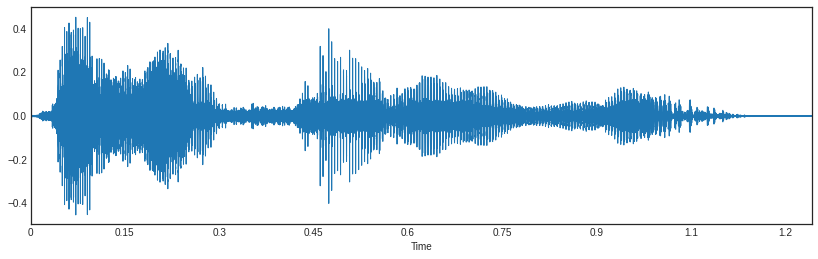

In [6]:
import librosa.display
from IPython.display import Audio

text = 'Hello, how are you?'
mel_outputs_postnet, alignments, audio_np, sampling_rate = TTS(text)

fig = plt.figure(figsize=(14, 4))
librosa.display.waveplot(audio_np, sr=sampling_rate)
Audio(audio_np, rate=sampling_rate)

Using cache found in /aiffel/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


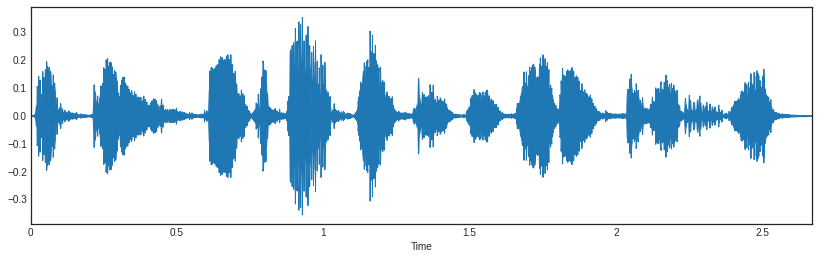

In [7]:
text = 'What do you think about speech synthesis?'
mel_outputs_postnet, alignments, audio_np, sampling_rate = TTS(text)

fig = plt.figure(figsize=(14, 4))
librosa.display.waveplot(audio_np, sr=sampling_rate)
Audio(audio_np, rate=sampling_rate)